In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import torch.utils.data as data
import matplotlib.pyplot as plt 
from tqdm import tqdm

# Target high-dim performance functions

In [2]:
from juan_first_passage import juan_first_passage
#https://rprepo.readthedocs.io/en/latest/reliability_problems.html#sec-rp-300
# RP300 14 input variables - gaussian
#set_id 	 problem_id
# 1 	 15

from gfun_213_le_frame import gfun_213_le_frame
from le_frame import le_frame
import le_frame_rein
# https://rprepo.readthedocs.io/en/latest/_modules/gfun_213_le_frame.html#gfun_213_le_frame
# set_id	problem_id
# 1 	14

# Creating classes for MLP

In [33]:
# class to create an MLP object
class MLP(nn.Sequential):
    def __init__(self, input_features, hidden_features, output_features):
        super().__init__(
            nn.Linear(input_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, hidden_features),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_features, output_features),
        )

Generating samples and splitting the data for training and test

In [6]:
n_samples = 10**6

# x_dataset_2 = np.random.normal(0, 1 , size=(n_samples, 14) )
# y_dataset_2 = juan_first_passage(x_dataset_2)

5.2e-05

In [5]:
# reading external dataset file 
filename_data = 'DataSet_RP300_10e6.sav'
dataset = pickle.load(open(filename_data, 'rb'))
x_dataset = dataset[:, 0:14]
y_dataset = dataset[:, 14]

## pf estimation with dataset
np.sum(y_dataset < 0)/len(y_dataset)

In [7]:
# dataset[:, 0:14] = x_dataset_2
# dataset[:, 14] = y_dataset_2

# filename_data = 'DataSet_RP300_10e6.sav'
# pickle.dump(dataset, open(filename_data, 'wb'))

n_split = int(0.3 * n_samples) #splitting 30 - 70 %

x_train = torch.from_numpy(x_dataset[n_split:].astype(np.float32))
y_train = torch.from_numpy(y_dataset[n_split:].astype(np.float32)).view(-1,1)

x_test = torch.from_numpy(x_dataset[:n_split].astype(np.float32))
y_test = torch.from_numpy(y_dataset[:n_split].astype(np.float32)).view(-1,1)

In [ ]:
if torch.cuda.is_available() == True:
    device = 'cuda'
else:
    device = 'cpu'
    
print(device)

# Training MLP

In [43]:
#  instantiate the network  
network = MLP(14, 128, 1)    #input, hidden, output size

print(network)

MLP(
  (0): Linear(in_features=14, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): LeakyReLU(negative_slope=0.2)
  (10): Linear(in_features=128, out_features=1, bias=True)
)


Setting up losses criterion, optimizer and dataloaders

In [48]:
# we use the MSE loss as criterion
criterion = nn.MSELoss()

# we create an instance of the SGD class that will make the updates for us
# optimizer = optim.SGD(params= network.parameters(), lr=.1)
optimizer = optim.Adam(params= network.parameters(), lr = 1e-3, weight_decay = 1e-8)

train = data.TensorDataset(x_train, y_train)
trainloader = data.DataLoader(train, batch_size=64, shuffle=True)

test = data.TensorDataset(x_test, y_test)
testloader = data.DataLoader(test, batch_size=64, shuffle=False)

10938it [00:56, 192.44it/s, loss=0.000119]
10938it [01:21, 134.60it/s, loss=0.000111]
10938it [01:13, 149.24it/s, loss=3.24e-5] 
10938it [00:59, 185.01it/s, loss=1.67e-5] 
10938it [00:57, 191.83it/s, loss=0.000161]
10938it [00:54, 202.08it/s, loss=5.34e-5] 
10938it [01:34, 115.85it/s, loss=5.6e-5]  
10938it [01:39, 110.46it/s, loss=4.67e-5] 
10938it [01:16, 143.02it/s, loss=3.16e-5] 
10938it [01:12, 151.19it/s, loss=3.1e-5]  
10938it [01:27, 124.86it/s, loss=2.92e-5] 
10938it [01:14, 146.45it/s, loss=2.71e-5] 
10938it [01:10, 155.05it/s, loss=4.21e-5] 
10938it [01:16, 142.43it/s, loss=2.13e-5] 
10938it [01:09, 157.76it/s, loss=2.38e-5] 
10938it [01:14, 147.72it/s, loss=8.22e-6] 
10938it [01:17, 140.80it/s, loss=3.55e-5] 
10938it [01:26, 126.86it/s, loss=2e-5]    
10938it [01:06, 165.11it/s, loss=2.46e-5] 
10938it [00:53, 204.27it/s, loss=2.02e-5] 
10938it [01:24, 129.30it/s, loss=2.51e-5] 
10938it [01:07, 162.33it/s, loss=2.54e-5] 
10938it [01:17, 141.99it/s, loss=2.22e-5] 
10938it [01

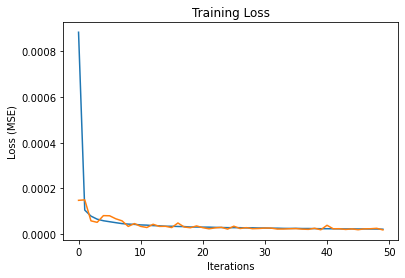

In [49]:
num_epochs = 50
train_avg_loss = []
test_avg_loss = []

device = 'cuda'

network.to(device)

for epoch in range(num_epochs):
    loop = tqdm(enumerate(trainloader))

    train_losses = []
    test_losses = []

    for i, (x, y) in loop:
        
        x = x.to(device)
        y = y.to(device)
        
        pred = network(x)
        loss = criterion(pred, y)
        train_losses.append(loss.detach())

        optimizer.zero_grad()   #turning gradients to zero
        loss.backward()         #to get the gradient only with respect the parameters
        optimizer.step()        #to update the network parameters

        loop.set_postfix(loss=loss.item())
        
    with torch.no_grad():   

        for x, y in testloader:
            x = x.to(device)
            y = y.to(device)
            
            pred = network(x)
            loss = criterion(pred, y)
            test_losses.append(loss)

    train_avg_loss.append(sum(train_losses)/len(train_losses))
    test_avg_loss.append(sum(test_losses)/len(test_losses))

# Move everything back to the CPU
train_avg_loss = torch.tensor(train_avg_loss, device = 'cpu')
test_avg_loss = torch.tensor(test_avg_loss, device = 'cpu')

fig, axs = plt.subplots(1, 1)
axs.set_title('Training Loss')
axs.plot(train_avg_loss)
axs.plot(test_avg_loss)
axs.set_xlabel('Iterations')
axs.set_ylabel('Loss (MSE)')
plt.show()

In [ ]:
# filename_data = 'network_MLP.sav'
# pickle.dump(network, open(filename_data, 'wb'))

Pf estimation

In [ ]:
# #loading network
# filename_data = 'network_MLP.sav'
# network = pickle.load(open(filename_data, 'rb'))

In [32]:
# Pf with MCS using the trained network

n_pred = 10**6
x_pred = np.random.normal(0, 1 , size=(n_samples, 14) )

device ='cpu'

x_pred = torch.from_numpy(x_pred.astype(np.float32)).to(device)

network.to(device)

y_pred = network(x_pred)   #MLP
np.sum(y_pred.cpu().detach().numpy() < 0)/len(y_pred)

0.0

In [24]:
torch.cuda.empty_cache()

In [ ]:
x_pred

In [ ]:
counts, bins = np.histogram(y_pred.cpu().detach().numpy())
plt.stairs(counts, bins)

In [ ]:
#to test a single point and compare it with the real output
point = 200
samplex = torch.from_numpy(x_dataset[point].astype(np.float32)).to(device)

y_dataset[point], network(samplex)

In [ ]:
network_AE = network_AE.to('cpu')

y_pred_AE = network_AE.encoder(x_pred)

y_pred_AE.shape

In [ ]:
lat_var = 2
counts, bins = np.histogram(y_pred_AE[:, lat_var].cpu().detach().numpy())
plt.stairs(counts, bins)

np.sum(y_pred.cpu().detach().numpy() < 0)

In [ ]:
negative = y_pred < 0
negative.sum(dim = 0)

In [ ]:
point = 10
samplex = x_dataset[point]
sampley = y_dataset[point]

samplex_torch = torch.from_numpy(x_dataset[point].astype(np.float32))

In [ ]:
np.array(sampley)

In [ ]:
(torch.from_numpy(np.array(sampley)) - network(samplex_torch))**2